# Transient CO<sub>2</sub>

In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
from itertools import product

import pandas as pd
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import cmocean

import cartopy
import cartopy.crs as ccrs

os.environ['CESMDATAROOT'] = '/glade/scratch/mclong/inputdata'
import pop_tools

import utils
import data_collections
import plot

from ncar_jobqueue import NCARCluster


In [17]:
cluster = NCARCluster(memory='10 GB')
cluster.scale(10) #adapt(minimum_jobs=0, maximum_jobs=24)
client

/glade/u/home/mgrover/miniconda3/envs/cesm2-marbl/lib/python3.7/site-packages/distributed/node.py:164: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40653 instead
  expected, actual


<Client: 'tcp://10.12.206.57:44211' processes=24 threads=24, memory=558.72 GiB>

In [26]:
experiments = [
    'historical',
    'SSP1-2.6',
    'SSP2-4.5',
    'SSP3-7.0',
    'SSP5-8.5',
]

In [27]:
query = dict(
    experiment=experiments,
    stream='pop.h',
)
glb_int = data_collections.global_integral_timeseries_ann(query)
glb_avg = data_collections.global_mean_timeseries_ann(query)
glb_int

{ 'esm_collection': 'data/campaign-cesm2-cmip6-timeseries.json',
  'name': 'global_mean_timeseries_ann',
  'operator_kwargs': [ { },
                       { 'include_ms': False,
                         'normalize': False},
                       { }],
  'operators': [ 'center_time',
                 'global_mean',
                 'resample_ann'],
  'preprocess': None,
  'query': { 'experiment': [ 'historical',
                             'SSP1-2.6',
                             'SSP2-4.5',
                             'SSP3-7.0',
                             'SSP5-8.5'],
             'stream': 'pop.h'}}

In [21]:
dsets_int = glb_int.to_dataset_dict('FG_CO2', clobber=False)
dsets_avg = glb_avg.to_dataset_dict(['ATM_CO2', 'SST',], prefer_derived=True, clobber=False)

assert dsets_int.keys() == dsets_avg.keys()

dsets = {}
for key in dsets_int.keys():
    dsets[key] = xr.merge((dsets_int[key], dsets_avg[key]))

dsets

{'ocn.historical.pop.h': <xarray.Dataset>
 Dimensions:                 (lat_aux_grid: 395, member_id: 11, moc_comp: 3, moc_z: 61, nlat: 384, nlon: 320, time: 165, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w: 60, z_w_bot: 60, z_w_top: 60)
 Coordinates: (12/13)
   * z_t_150m                (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
     TLONG                   (nlat, nlon) float64 320.6 321.7 ... 319.4 319.8
     TLAT                    (nlat, nlon) float64 -79.22 -79.22 ... 72.19 72.19
   * member_id               (member_id) int64 1 2 3 4 5 6 7 8 9 10 11
   * z_t                     (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
   * moc_z                   (moc_z) float32 0.0 1e+03 2e+03 ... 5.25e+05 5.5e+05
     ...                      ...
   * z_w                     (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
   * z_w_bot                 (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
   * z_w_top                 (z_w_top) float32 0.0 1e+03 2e+0

In [7]:
del client
del cluster

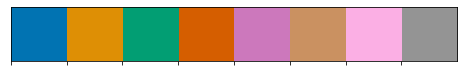

In [22]:
import seaborn as sns

current_palette = sns.color_palette('colorblind', 8)
sns.palplot(current_palette)

exp_colors = {
    'PI': current_palette.as_hex()[-1],
    'historical': 'k',
    'SSP1-2.6': current_palette.as_hex()[0],
    'SSP2-4.5': current_palette.as_hex()[1],
    'SSP3-7.0': current_palette.as_hex()[2],
    'SSP5-8.5': current_palette.as_hex()[3],
}

In [23]:
variable_labels = dict(
    year='Year',
    FG_CO2='Air-sea CO$_2$ flux [Pg C yr$^{-1}$]',
    photoC_TOT_zint_100m='NPP (z > -100m) [Pg C yr$^{-1}$]',
    photoC_TOT_zint='NPP [Pg C yr$^{-1}$]',
    POC_FLUX_100m='POC flux (100 m) [Pg C yr$^{-1}$]',
    ATM_CO2='Atmospheric CO$_2$ [ppm]',
    SST='Temperature [°C]',
    time='',
)

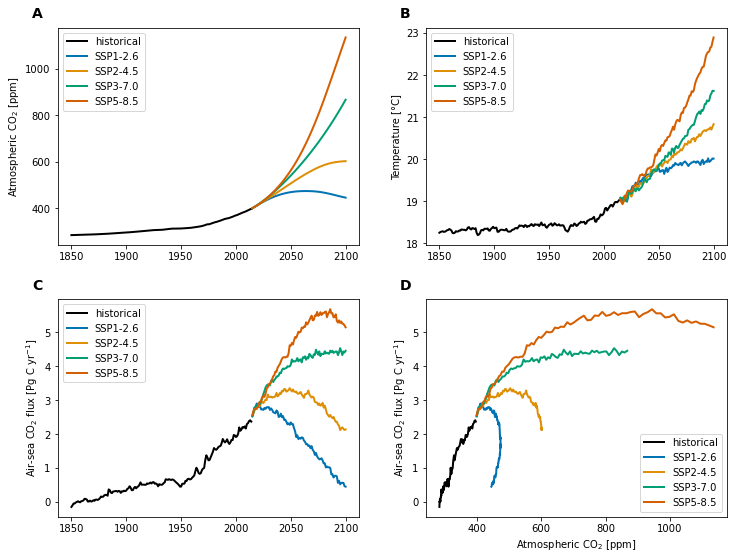

In [24]:
y = 'FG_CO2'
x = 'SST'

nrow = 2
ncol = 2
#fig, axs = plt.subplots(nrow, ncol, figsize=(4*ncol, 3*nrow), constrained_layout=False)

fig = plt.figure(figsize=(12, 9))
gs = gridspec.GridSpec(
    nrows=2, ncols=2, 
    hspace=0.25,
    wspace=0.22,
)
axs = np.empty((2, 2)).astype(object)
for i, j in product(range(2), range(2)):
    axs[i, j] = plt.subplot(gs[i, j])



X = [['time', 'time'], ['time', 'ATM_CO2'],]
Y = [['ATM_CO2', 'SST'], ['FG_CO2', 'FG_CO2'],]

for i, j in product(range(2), range(2)):
    ax = axs[i, j]
    x = X[i][j]
    y = Y[i][j]
    for exp in experiments:
        ds = dsets[f'ocn.{exp}.pop.h']
        #for member_id in ds.member_id.values:
        #    ax.plot(ds.time, ds[v].sel(member_id=member_id), '-', alpha=0.25, linewidth=1, color=exp_colors[exp])
        ax.plot(ds.mean('member_id')[x], ds.mean('member_id')[y], '-', linewidth=2, color=exp_colors[exp], label=exp)
        
    ax.set_ylabel(variable_labels[y])    
    ax.legend()
    ax.set_xlabel(variable_labels[x])
utils.label_plots(fig, [ax for ax in axs.ravel()], xoff=-0.03, yoff=0.015)   

utils.savefig(f'global-timeseries-FG_CO2.pdf')

In [25]:
baseline = dsets['ocn.historical.pop.h'].SST.isel(time=slice(0, 10)).mean()
for exp, ds in dsets.items():
    if 'SSP' in exp:
        warming = ds.SST.isel(time=-1).mean() - baseline
        print(f'{exp}: {warming.values:0.2f}')

ocn.SSP5-8.5.pop.h: 4.60
ocn.SSP3-7.0.pop.h: 3.33
ocn.SSP1-2.6.pop.h: 1.72
ocn.SSP2-4.5.pop.h: 2.54
